# Exploration of the textual dataset with labels integration


Dans ce notebook, on se propose d'intégrer les classes à prédire du jeu de données d'entraînement `Y_train.csv`, que l'on nommera `labels` au dataset d'entraînement `X_train.csv` utilisé et exploré dans le notebook `exploration-text-1.ipynb`. On notera ce dernier `data`.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Dans la suite, certains modules de NLP seront utiles, on les importe immédiatement.


In [2]:
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer


# get the stopwords
nltk.download('stopwords')
stopwds = set(stopwords.words('french'))

added_stopwds= {'je', 'tu', 'il', 'elle', 'nous', 'vous', 'ils', 'elles', 'me', 'te', 'se', 'moi', 'toi', 'soi', 'leur', 'lui',
                   'en', 'y', 'ce', 'cela', 'ça', 'ceci', 'celui', 'celle', 'ceux', 'celles','mon', 'ton', 'son', 'notre', 'votre',
                   'leur', 'mes', 'tes', 'ses', 'nos', 'vos', 'leurs', 'le', 'la', 'les', 'un', 'une', 'des', 'du', 'de', 'au', 'aux',
                   'ce', 'ces', 'cet', 'cette', 'être', 'avoir', 'faire', 'aller', 'venir', 'pouvoir', 'devoir', 'savoir', 'dire',
                   'voir', 'mettre', 'prendre', 'donner', 'vouloir', 'falloir', 'et', 'ou', 'mais', 'donc', 'or', 'ni', 'car', 'par',
                   'pour', 'dans', 'sur', 'sous', 'avec', 'sans', 'entre', 'chez', 'vers', 'selon', 'depuis', 'pendant', 'autour',
                   'après', 'avant', 'si', 'quand', 'comme', 'bien', 'très', 'trop', 'peu', 'aussi', 'encore', 'déjà', 'toujours',
                   'jamais', 'parfois', 'souvent', 'moins', 'plus', 'autant', 'alors', 'ensuite', 'également', 'tout', 'tous',
                   'toutes', 'chaque', 'aucun', 'certaines', 'certains', 'plusieurs', 'autre', 'autres', 'même', 'tel', 'tels',
                   'tellement', 'chose', 'truc', 'cas', 'façon', 'manière', 'genre', 'type'}
stopwds.update(added_stopwds)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wsladmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1 - Preparation of the dataset

Avant d'explorer le dataset complet, il doit être préparé. On va reconstruire les colonnes créées dans le notebook `exploration-text-1.ipynb`, à savoir les colonnes qui dénombrent les tailles des titres et descriptions des produits. Les colonnes `productid` et `imageid` seront retirées (elles seront utiles pour une exploration liées aux images) et `labels` et `data` seront rattachés pour former le dataset global `df`.


In [3]:
data = pd.read_csv('../../data/X_train.csv', index_col=0).drop(columns=['productid', 'imageid'])

data['designation_length'] = data['designation'].apply(lambda s: len(s))  # length of designation
data['description_length'] = data['description'].apply(lambda s: len(s) if isinstance(s, str) else 0)  # length of description

labels = pd.read_csv('../../data/Y_train.csv', index_col=0)

df = pd.concat([data, labels], axis=1)

display(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   designation         84916 non-null  object
 1   description         55116 non-null  object
 2   designation_length  84916 non-null  int64 
 3   description_length  84916 non-null  int64 
 4   prdtypecode         84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


None

,designation,description,designation_length,description_length,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,88,0,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,206,0,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,76,760,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,63,0,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,20,213,2705


On a maintenant un dataset prêt à être explorer.


## 2 - Labels

On va extraire des informations essentielles sur les différentes classes pour assurer un prétraitement pertinent. Cela inclut notamment le nombre de classes, la répartition des données dans les classes, les relations des features avec les classes. Renommons d'abord la colonne des labels.


In [4]:
df = df.rename(columns={'prdtypecode': 'labels'})


### 2.1 - Statistics

On détermine les statistiques de base concernant les labels.


In [5]:
print(f"Number of classes : {df['labels'].nunique()}")
print(f"Values of labels : {df['labels'].unique()}")


Number of classes : 27
Values of labels : [  10 2280   50 1280 2705 2522 2582 1560 1281 1920 2403 1140 2583 1180
 1300 2462 1160 2060   40   60 1320 1302 2220 2905 2585 1940 1301]


On a donc $27$ classes différentes, c'est donc un problème de classification qui ne peut pas être considéré comme un problème de petite dimension. On note aussi que les valeurs de chaque classe ne sont pas pertinentes dans le sens où elles ne contiennent _a priori_ aucune information digeste. On pourra donc librement renommer les classes avec des valeurs plus standards ($1$ à $27$ par exemple). Analysons la distribution des classes au sein des données.


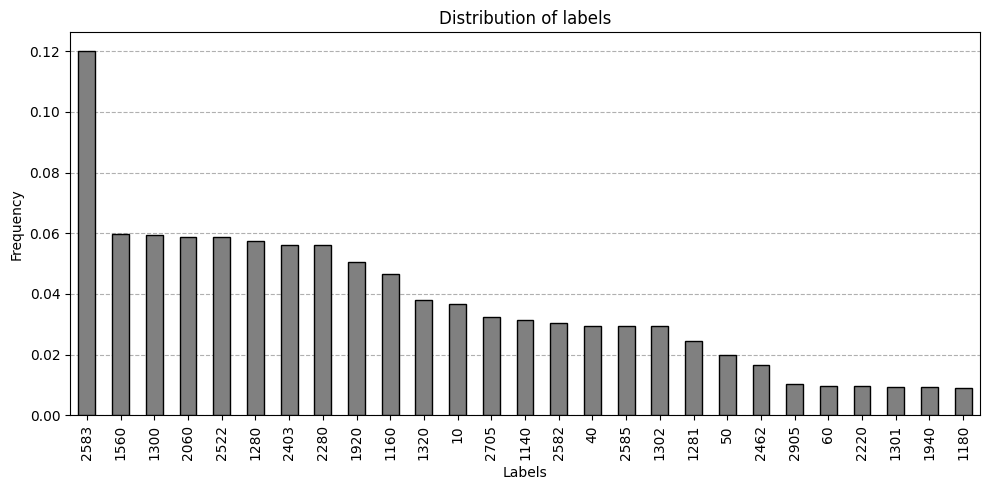

In [6]:
labels_repartition = df['labels'].value_counts(normalize=True)  # frequency of each class


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

labels_repartition.plot(kind='bar', color='gray', edgecolor='black', ax=ax, zorder=3)

ax.set_title('Distribution of labels')
ax.set_xlabel('Labels')
ax.set_ylabel('Frequency')
ax.grid(visible=True, linestyle='--', axis='y', zorder=0)

plt.tight_layout()

plt.show()


On note immédiatement que la distribution des classes est sensiblement hétérogène, avec notamment le label $2583$ qui est sur-représenté au sein des données tandis que d'autres sont sous-représentés. Il en résulte qu'un ré-échantillonnage des données est nécessaire pour améliorer le pouvoir prédictif des futures modèles. On peut penser notamment à :
- L'under-sampling des labels sur-représentés (le jeu de données reste très volumineux)
- L'over-sampling des labels sous-représentés (conserve toute la richesse du jeu de données)


### 2.2 Advanced analysis

Pour définir les techniques utilisées, il peut être intéressant de mettre en évidence la qualité des données disponibles pour chaque classe. En particulier, il est judicieux d'identifier si certaines classes ont une plus grande proportion de valeurs manquantes (colonne `description`). Suite aux analyses du notebook `exploration-text-1.ipynb`, on va aussi déterminer la taille moyenne des titres pour chaque classe, qui pourra affiner l'analyse (on rappelle que des titres *longs* pourront être considérés comme des descriptions).


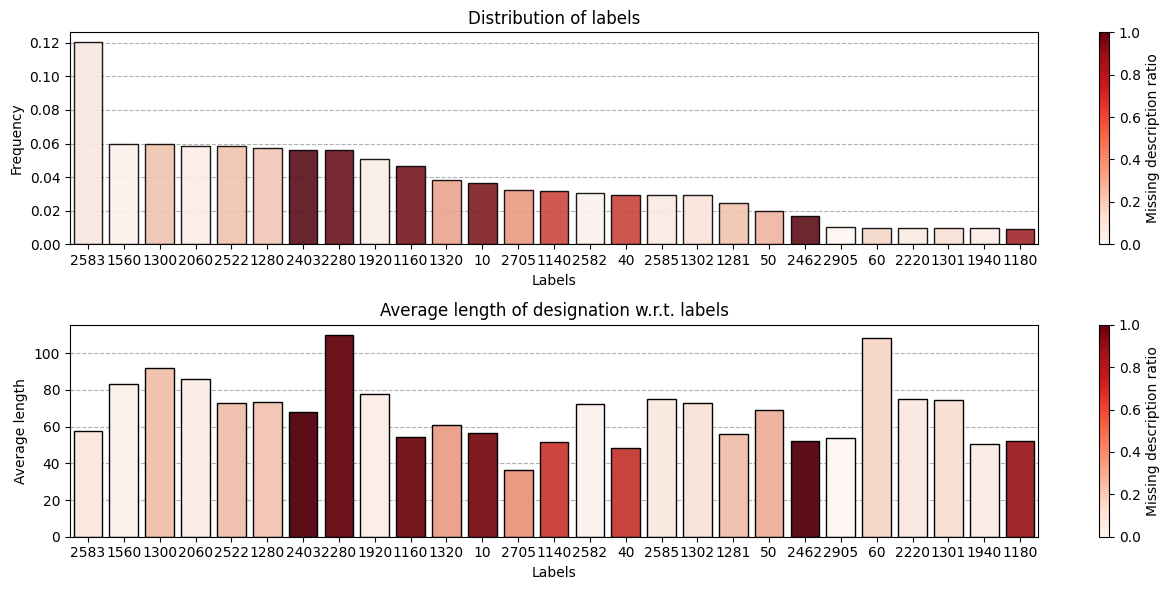

In [7]:
df['missing_description'] = df['description'].isna().astype('int')  # indicates if decription is missing

# define how to aggregate for each column (labels, missing_description, designation_length)
for_agg = {'label_count': pd.NamedAgg(column='labels', aggfunc='count'),
           'missing_count': pd.NamedAgg(column='missing_description', aggfunc='sum'),
           'avg_designation_length': pd.NamedAgg(column='designation_length', aggfunc='mean')}

labels_aggs = df[['designation_length', 'missing_description', 'labels']].groupby(['labels']).agg(**for_agg)  # group by labels and aggregate with for_agg
labels_aggs['label_freq'] = labels_aggs['label_count'] / df.shape[0]  # compute the frequencies of each class
labels_aggs['missing_ratio'] = labels_aggs['missing_count'] / labels_aggs['label_count']  # compute the ratio of missing description for each class

sorted_labels_freqs = labels_aggs.sort_values(by='label_freq', ascending=False)[['label_freq', 'missing_ratio', 'avg_designation_length']]  # sort by descending class frequency
x = sorted_labels_freqs.index.astype('str')  # get indexes as strings for good plotting


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 6))

sns.barplot(data=sorted_labels_freqs, x=x, y=sorted_labels_freqs['label_freq'], hue='missing_ratio', palette='Reds', edgecolor='black', zorder=2, alpha=0.9, ax=ax[0])
sns.barplot(data=sorted_labels_freqs, x=x, y=sorted_labels_freqs['avg_designation_length'], hue='missing_ratio', palette='Reds', edgecolor='black', zorder=2, ax=ax[1])

ax[0].set_title('Distribution of labels')
ax[0].set_xlabel('Labels')
ax[0].set_ylabel('Frequency')
ax[0].grid(visible=True, linestyle='--', axis='y', zorder=0)
ax[0].legend().remove()
sm = plt.cm.ScalarMappable(cmap='Reds')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0])
cbar.set_label('Missing description ratio')

ax[1].set_title('Average length of designation w.r.t. labels')
ax[1].set_xlabel('Labels')
ax[1].set_ylabel('Average length')
ax[1].grid(visible=True, linestyle='--', axis='y', zorder=0)
ax[1].legend().remove()
sm = plt.cm.ScalarMappable(cmap='Reds')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1])
cbar.set_label('Missing description ratio')

plt.tight_layout()

plt.show()


On note tout d'abord qu'il y a $8$ classes dont la proportion de descriptions manquantes est particulièrement élevée : les classes $2403$, $2280$, $1160$, $10$, $1140$, $40$, $2462$, et $1180$. A l'exception de la classe $2280$, les longueurs moyennes des titres pour ces classes ne permettent pas de conclure que les valeurs manquantes proviennent du fait que les descriptions sont incluses dans les titres. Pour la classe $2280$, La longueur moyenne est considérablement plus élevée, ce qui peut s'expliquer soit par la présence des descriptions dans les titres, soit par la nature de la classe qui représenterait des produits dont les titres sont intrinsèquement plus long.

Notons qu'étant donné que ces $8$ classes ont une proportion de valeurs manquantes très élevée, il devient obligatoire de compléter la colonne `description` pour ne pas perdre d'information et voir certaines classes mal prédites par les modèles. L'idée de supprimer les valeurs manquantes est à abandonner tout comme l'idée d'exclure cette colonne. En effet, certaines classes ont une très bonne proportion de valeurs manquantes (faible à nulle), on perdrait alors des informations importantes pour appuyer les modèles dans la classification des produits.

Essayons maintenant d'identifier la nature des produits pour différentes classes. Plusieurs options sont possibles, notamment :
- identification exhaustive : on balaye chaque classe et on détermine à l'aide des données le produit qui est représenté.
- identification statistique : on analyse le champ lexical des données pour chaque classe et on extrait le ou les mots qui ressortent le plus, qui fournira un thème de produit représenté.

On se propose dans la suite d'identifier le champ lexical des classes à l'aide de nuage de mots, basé sur le module wordcloud. On va fusionner les colonnes `designation` et `description`, puis aggréger cette colonne par concaténation en groupant par classe. On utilisera nltk et les expressions régulières pour nettoyer grossièrement les données textuelles.


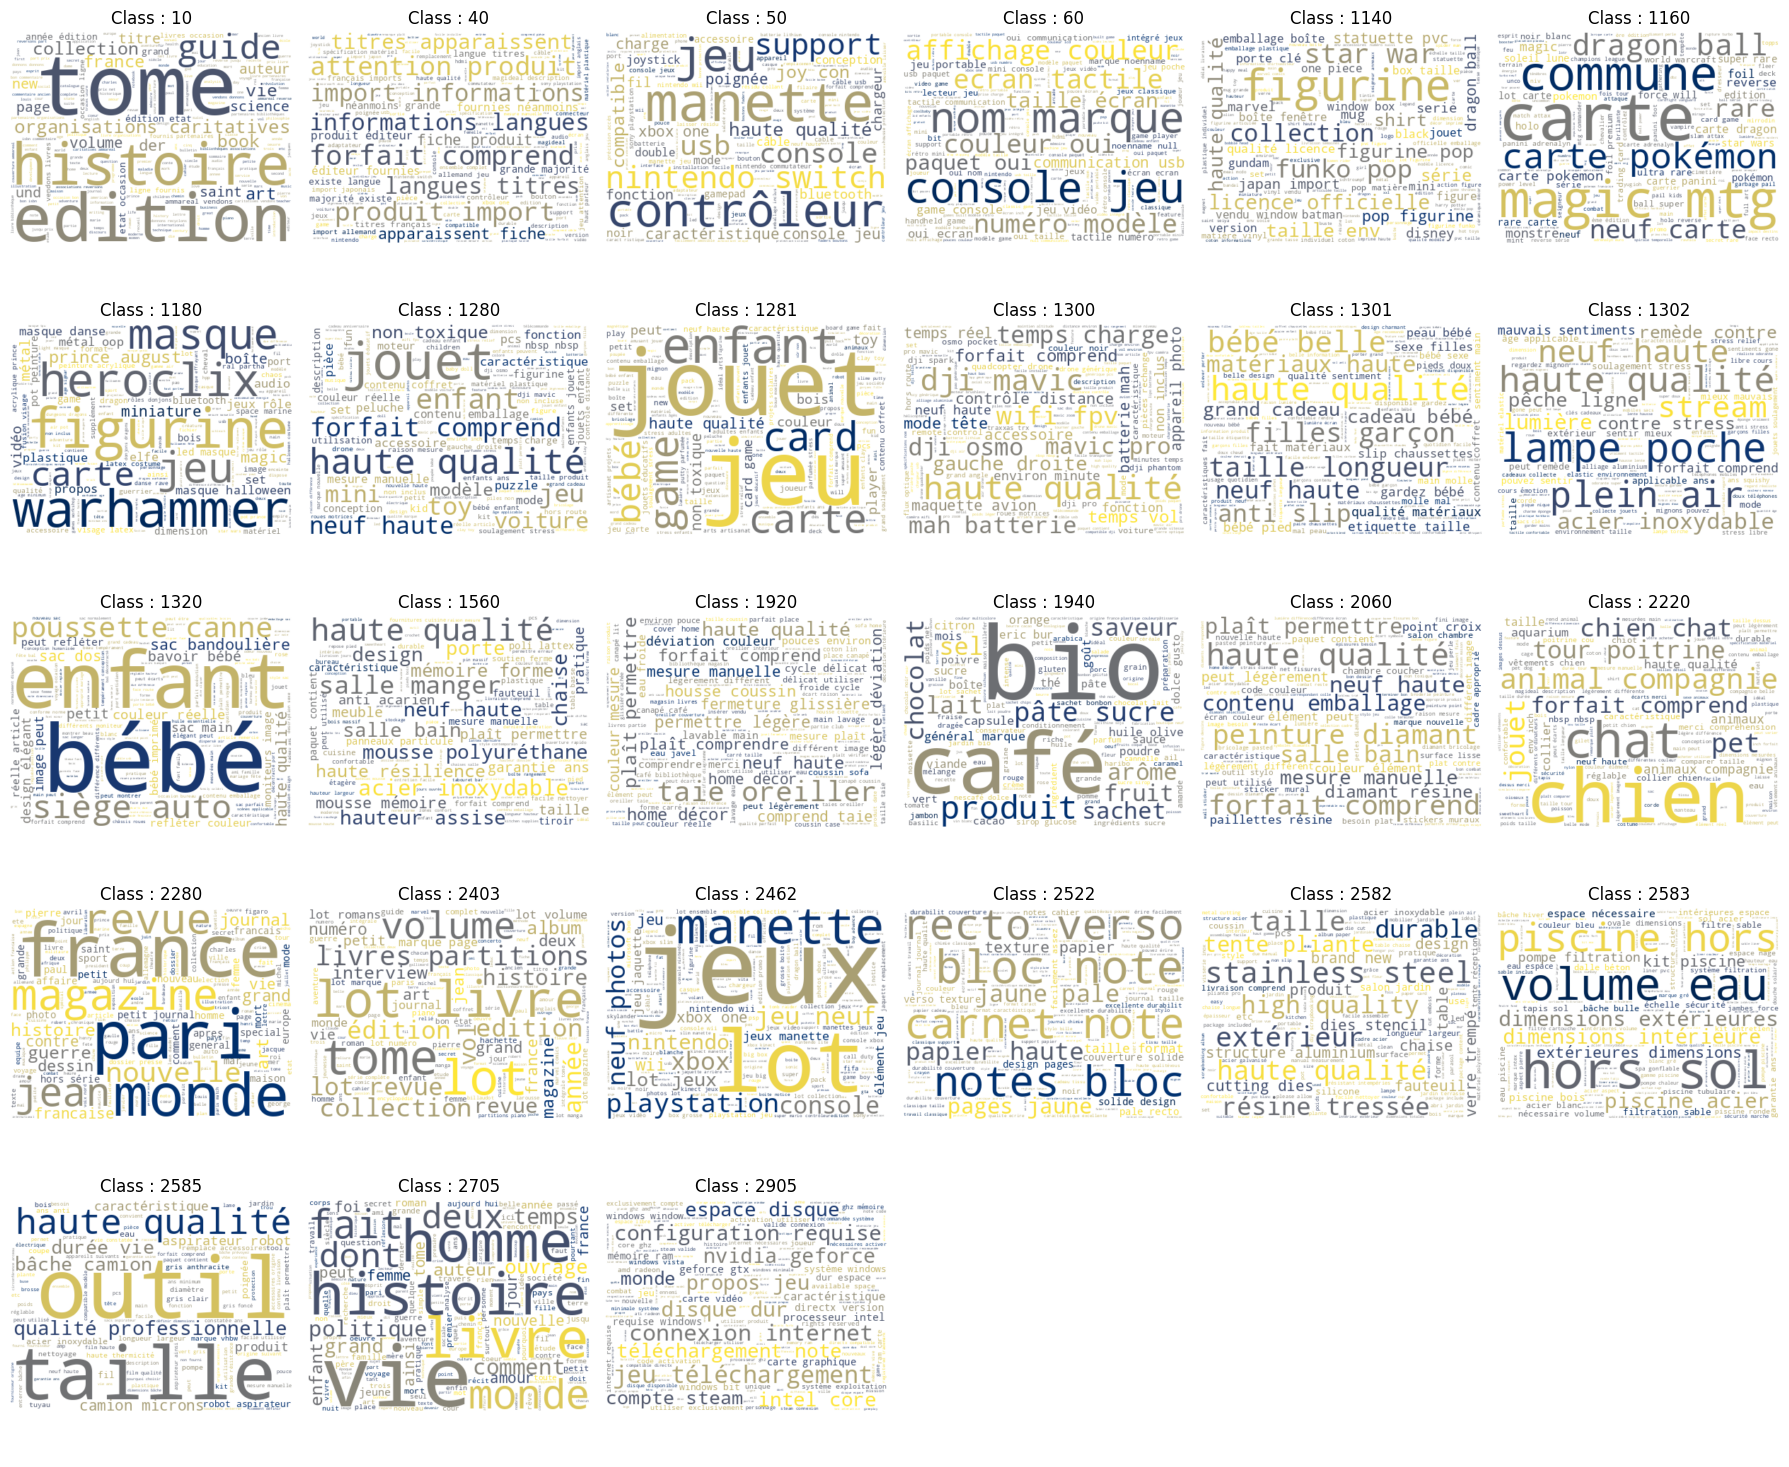

In [8]:
# a quick basic clean of the text
def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s]", " ", text)  # keep letters and accents
    text = re.sub(r"\s+", " ", text)  # clean spaces
    words = text.split()
    words = [w for w in words if w not in stopwds and len(w) > 2]  # keep useful words
    return " ".join(words)

# a quick step to extract text from html files
def throw_html_elem(text: str) -> str:
    return BeautifulSoup(text, "html.parser").get_text(separator=" ")

df['lexical_field'] = df['designation'].fillna('') + ' ' + df['description'].fillna('')  # create a column by merging designation and description

df['lexical_field'] = df['lexical_field'].apply(lambda s: basic_clean(throw_html_elem(s)))  # apply a quick clean to the texts

grouped_lexical_field = df[['labels', 'lexical_field']].groupby(['labels']).agg({'lexical_field': lambda s: ' '.join(s)}).reset_index()  # group by class and concatenate all texts for each class
classes, lexical_fields = grouped_lexical_field['labels'], grouped_lexical_field['lexical_field']

# make the wordclouds for each class
wordclouds = {label: WordCloud(width=400, height=300, background_color='white', colormap='cividis').generate(text)
              for label, text in zip(classes, lexical_fields)}


fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(18, 15))
ax = ax.flatten()

# plotting the wordclouds
for i, (c, wc) in enumerate(wordclouds.items()):
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].set_title(f'Class : {c}', fontsize=12)
    ax[i].axis('off')

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()


On note immédiatement que certaines classes ont un champ lexical très marqué et relativement simple à identifier (par exemple, la classe $50$ correspond à des produits de l'univers du jeu vidéo et des consoles, la classe $2905$ quant à elle correspond à des produits de l'univers de l'informatique). D'autres classes ont un champs lexical qui semble plus difficile à cerner, notamment la classe $40$ où à l'exception du mot "langue", il peut être assez délicat d'inférer l'univers dans lequel les produits s'inscrivent. De manière générale, on pourra relativement bien identifier quelle classe correspond à quel univers de produit.

Il est aussi important de noter que certaines classes semblent être associées à des univers particulièrement proches : les classes $50$ et $2462$ par exemple semblent toutes les deux pointer vers l'univers du jeu vidéo. La séparation des classes peut s'expliquer par l'étendue de ce qui peut être trouvé dans la catégorie "jeu vidéo" (on peut facilement sous-catégoriser par accessoires, consoles, jeux, etc..). Il sera alors important de définir une stratégie lors du développement des modèles, et surtout de prendre en compte le fait que deux classes peuvent potentiellement correspondre à une même catégorie générique. On pourra alors explorer des techniques de classification progressive pour les classes avec des ressemblances trop fortes (clustering des classes puis classification intra-cluster dans les différentes classes présentes par des sous-modèles plus fins, etc).

Par ailleurs, on pourra relabelliser les classes de sorte que les données soient plus digestes et que l'analyse des prédictions des modèles soit facilitée.

Terminons l'analyse en construisant une matrice de corrélation entre les classes. On va d'abord vectoriser les données textuelles traitées précédemment pour les word clouds.


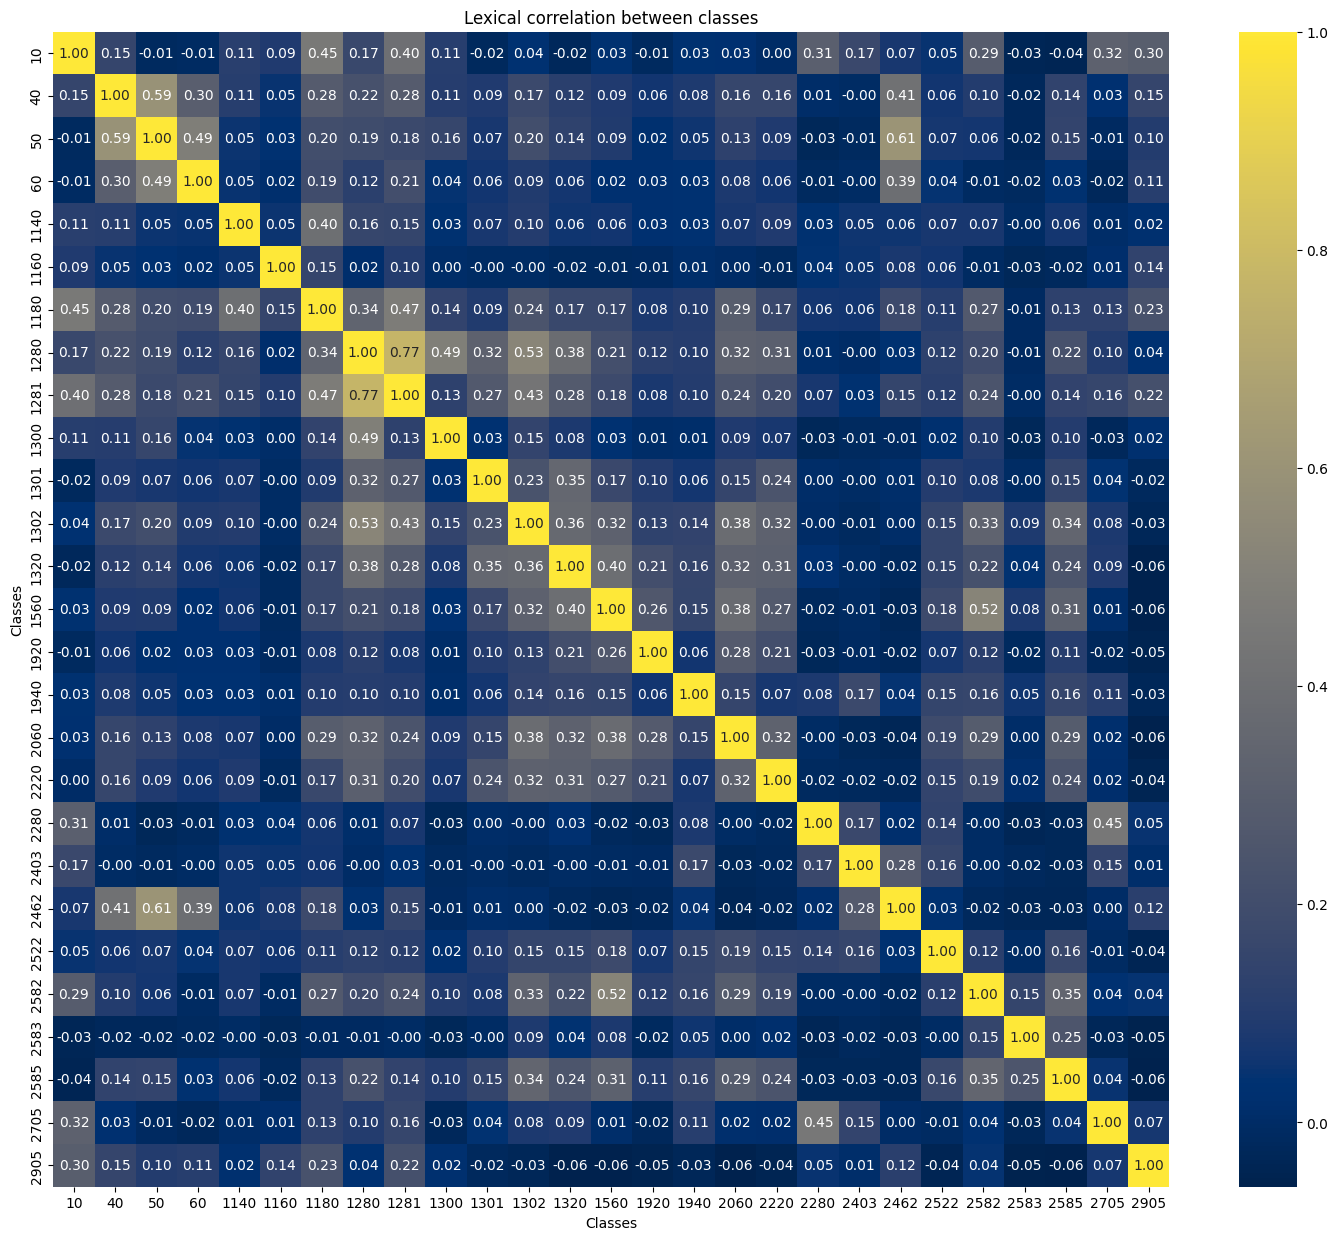

In [9]:
# create a vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
vectorized_text = vectorizer.fit_transform(grouped_lexical_field['lexical_field'])  # vectorize the texts

# compute correlation matrix
tmp_vectorized_text = pd.DataFrame(vectorized_text.toarray(), index=grouped_lexical_field['labels'], columns=vectorizer.get_feature_names_out())
correlation_matrix = tmp_vectorized_text.T.corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 15))

sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt=".2f")

ax.set_xlabel('Classes')
ax.set_ylabel('Classes')

plt.title("Lexical correlation between classes")
plt.show()


On retrouve des corrélations fortes sur les classes avec un champ lexical rapproché (notamment les exemples vus au-dessus). Dans l'ensemble, les classes sont tout de même bien décorrélées lexicalement. On peut raisonnablement conclure que le jeu de données textuelles fournira une bonne base pour le travail de classification, qui *in fine* pourra permettre d'obtenir de bons résultats relativement aux métriques utilisées.


## 3 - Conclusion

Dans ce notebook, on a mis en évidence plusieurs caractéristiques des classes présentes dans le dataset. Parmi les éléments les plus importants, on peut noter :
- 27 classes observées dans le dataset, suggérant de travailler sur des modèles suppportant des dimensions relativement élevées.
- Non-uniformité de la répartition des classes au sein du dataset, soulevant un problème de ré-échantillonnage pour se prémunir des biais qui peuvent en résulter.
- Forte hétérogénéité entre les classes sur le taux de valeurs manquantes de la colonne `description`, amenant à réaliser un fort pré-traitement de cette colonne pour éviter de pénaliser les classes mal complétées.
- Classes lexicalement bien dispersées et décorrélées, mais des similarités lexicales entre certaines classes demande à réfléchir sur l'utilité de clustering avant injection des données dans le modèle principal.
- Des labels de classes indigeste pour un humain à renommer (*a minima* en interne) en fonction du champ lexical de la classe.

Ce notebook clos l'exploration du dataset textuel en lien avec les classes à prédire. Dans la suite, on se propose d'explorer le dataset d'images ainsi que son rapprochement avec les classes à prédire. La première étape constitue le notebook `exploration-image-1.ipynb`. 
